<a href="https://colab.research.google.com/github/sukilsiva/Machine-Learnig-Deep-Learning-Code/blob/master/DCGAN_Face_Dataset_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow 
from tensorflow import keras 
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
#tqdm for a progress bar when loading the dataset
from tqdm import tqdm
import os

Using TensorFlow backend.


In [0]:
!git clone https://github.com/arvindrvs/nsfw_face.git

fatal: destination path 'nsfw_face' already exists and is not an empty directory.


In [0]:
class FaceGenerator:
    #RGB-images: 3-channels, grayscale: 1-channel, RGBA-images: 4-channels
    def __init__(self,image_width,image_height,channels):
        self.image_width = image_width
        self.image_height = image_height

        self.channels = channels

        self.image_shape = (self.image_width,self.image_height,self.channels)

        #Amount of randomly generated numbers for the first layer of the generator.
        self.random_noise_dimension = 100

        #Just 10 times higher learning rate would result in generator loss being stuck at 0.
        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
        self.generator = self.build_generator()

        #A placeholder for the generator input.
        random_input = Input(shape=(self.random_noise_dimension,))

        #Generator generates images from random noise.
        generated_image = self.generator(random_input)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        #Discriminator attempts to determine if image is real or generated
        validity = self.discriminator(generated_image)

        #Combined model = generator and discriminator combined.
        #1. Takes random noise as an input.
        #2. Generates an image.
        #3. Attempts to determine if image is real or generated.
        self.combined = Model(random_input,validity)
        self.combined.compile(loss="binary_crossentropy",optimizer=optimizer)

    def get_training_data(self,datafolder):
        print("Loading training data...")

        training_data = []
        
        #datadir = "/content/nsfw_face/dataSet"
        
        for img in os.listdir(datafolder):
          img = Image.open(os.path.join(datafolder,img))
          img = img.resize((64,64),Image.ANTIALIAS)
          pixels_array = np.asarray(img)
          training_data.append(pixels_array)
        
        training_data = np.reshape(training_data, (-1,64,64,3))
        return training_data

    def build_generator(self):
        #Generator attempts to fool discriminator by generating new images.
        model = Sequential()

        model.add(Dense(256*4*4,activation="relu",input_dim=self.random_noise_dimension))
        model.add(Reshape((4,4,256)))

        #Four layers of upsampling, convolution, batch normalization and activation.
        # 1. Upsampling: Input data is repeated. Default is (2,2). In that case a 4x4x256 array becomes an 8x8x256 array.
        # 2. Convolution: If you are not familiar
        # 3. Normalization normalizes outputs from convolution.
        # 4. Relu activation:  f(x) = max(0,x). If x < 0, then f(x) = 0.


        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(256,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(128,kernel_size=3,padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))


        # Last convolutional layer outputs as many featuremaps as channels in the final image.
        model.add(Conv2D(self.channels,kernel_size=3,padding="same"))
        # tanh maps everything to a range between -1 and 1.
        model.add(Activation("tanh"))

        # show the summary of the model architecture
        model.summary()

        # Placeholder for the random noise input
        input = Input(shape=(self.random_noise_dimension,))
        #Model output
        generated_image = model(input)

        #Change the model type from Sequential to Model 
        return Model(input,generated_image)


    def build_discriminator(self):
        #Discriminator attempts to classify real and generated images
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.image_shape, padding="same"))
        #Leaky relu is similar to usual relu. If x < 0 then f(x) = x * alpha, otherwise f(x) = x.
        model.add(LeakyReLU(alpha=0.2))

        #Dropout blocks some connections randomly. This help the model to generalize better.
        #0.25 means that every connection has a 25% chance of being blocked.
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        #Zero padding adds additional rows and columns to the image. Those rows and columns are made of zeros.
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dropout(0.25))
        #Flatten layer flattens the output of the previous layer to a single dimension.
        model.add(Flatten())
        #Outputs a value between 0 and 1 that predicts whether image is real or generated. 0 = generated, 1 = real.
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        input_image = Input(shape=self.image_shape)

        #Model output given an image.
        validity = model(input_image)

        return Model(input_image, validity)

    def train(self, datafolder ,epochs,batch_size,save_images_interval):
        #Get the real images
        training_data = self.get_training_data(datafolder)

        #Map all values to a range between -1 and 1.
        training_data = training_data / 127.5 - 1.

        #Two arrays of labels. Labels for real images: [1,1,1 ... 1,1,1], labels for generated images: [0,0,0 ... 0,0,0]
        labels_for_real_images = np.ones((batch_size,1))
        labels_for_generated_images = np.zeros((batch_size,1))

        for epoch in range(epochs):
            # Select a random half of images
            indices = np.random.randint(0,training_data.shape[0],batch_size)
            real_images = training_data[indices]

            #Generate random noise for a whole batch.
            random_noise = np.random.normal(0,1,(batch_size,self.random_noise_dimension))
            #Generate a batch of new images.
            generated_images = self.generator.predict(random_noise)

            #Train the discriminator on real images.
            discriminator_loss_real = self.discriminator.train_on_batch(real_images,labels_for_real_images)
            #Train the discriminator on generated images.
            discriminator_loss_generated = self.discriminator.train_on_batch(generated_images,labels_for_generated_images)
            #Calculate the average discriminator loss.
            discriminator_loss = 0.5 * np.add(discriminator_loss_real,discriminator_loss_generated)

            #Train the generator using the combined model. Generator tries to trick discriminator into mistaking generated images as real.
            generator_loss = self.combined.train_on_batch(random_noise,labels_for_real_images)
            print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, discriminator_loss[0], 100*discriminator_loss[1], generator_loss))

            if epoch % save_images_interval == 0:
                self.save_images(epoch)

        #Save the model for a later use
        self.generator.save("saved_models/facegenerator.h5")


    def save_images(self,epoch):
        #Save 25 generated images for demonstration purposes using matplotlib.pyplot.
        rows, columns = 5, 5
        noise = np.random.normal(0, 1, (rows * columns, self.random_noise_dimension))
        generated_images = self.generator.predict(noise)

        generated_images = 0.5 * generated_images + 0.5

        figure, axis = plt.subplots(rows, columns)
        image_count = 0
        for row in range(rows):
            for column in range(columns):
                axis[row,column].imshow(generated_images[image_count, :], cmap='spring')
                axis[row,column].axis('off')
                image_count += 1
        figure.savefig("generated_images/generated_%d.png" % epoch)
        plt.close()

    def generate_single_image(self,model_path,image_save_path):
        noise = np.random.normal(0,1,(1,self.random_noise_dimension))
        model = load_model(model_path)
        generated_image = model.predict(noise)
        #Normalized (-1 to 1) pixel values to the real (0 to 256) pixel values.
        generated_image = (generated_image+1)*127.5
        print(generated_image)
        #Drop the batch dimension. From (1,w,h,c) to (w,h,c)
        generated_image = np.reshape(generated_image,self.image_shape)

        image = Image.fromarray(generated_image,"RGB")
        image.save(image_save_path)

if __name__ == '__main__':
    facegenerator = FaceGenerator(64,64,3)
    facegenerator.train(datafolder="/content/nsfw_face/dataSet",epochs=50, batch_size=32, save_images_interval=100)
    facegenerator.generate_single_image("saved_models/facegenerator.h5","test.png")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 17, 17, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 64)        256       
_______________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Discriminator loss: 2.055593, acc.: 15.62%] [Generator loss: 0.571140]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


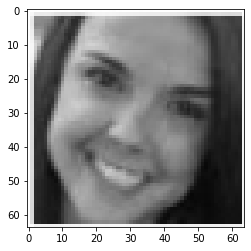

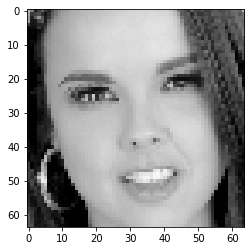

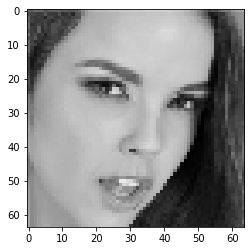

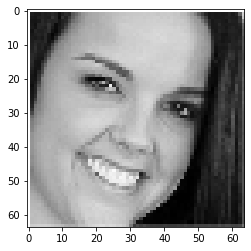

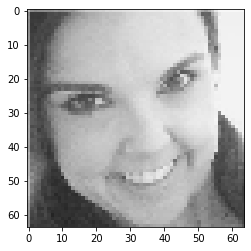

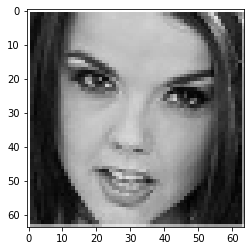

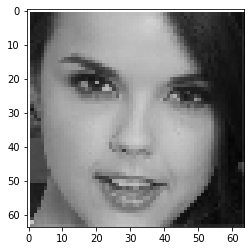

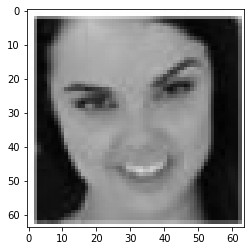

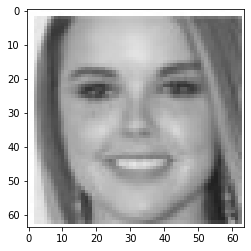

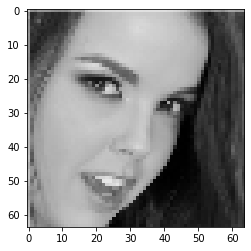

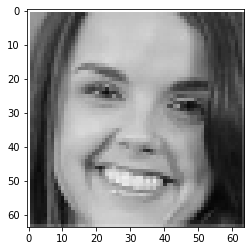

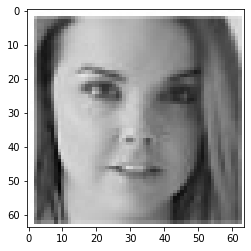

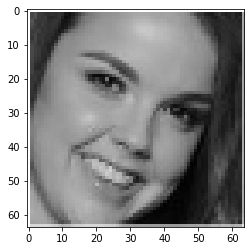

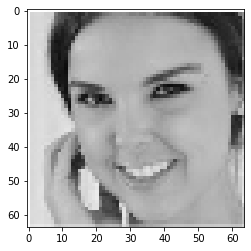

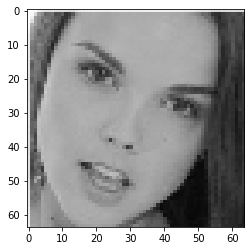

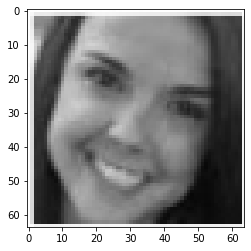

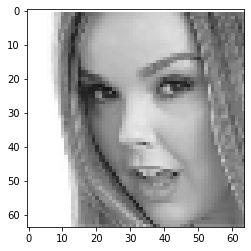

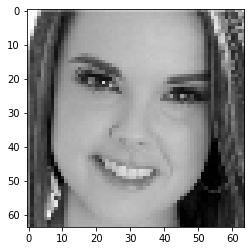

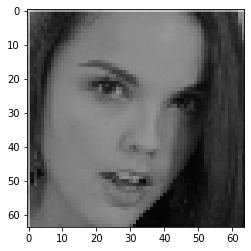

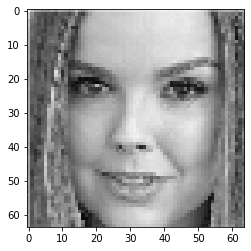

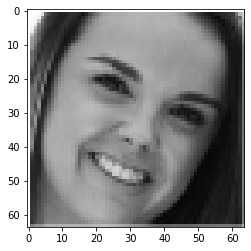

In [8]:
#to see what the real images look like 
import cv2

datadir = "/content/nsfw_face/dataSet"

path = os.path.join(datadir)
for img in os.listdir(path):
  img_array = cv2.imread(os.path.join(path, img))
  new_array = cv2.resize(img_array, (64,64))
  plt.imshow(new_array)
  plt.show()